In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
import matplotlib.pylab as pylab
import ipywidgets as widgets
from os import path
from sklearn.decomposition import PCA
from matplotlib.offsetbox import AnchoredText
from IPython.display import clear_output
from IPython.display import display
%matplotlib inline

In [461]:
class DataLoader:
    def __init__(self, path):
        self.__kall = None
        self.__rsem = {}
        self.__path = path
        
    def __loadKall(self):
        kallDF = pd.read_csv("{path}/NormalizedKallistoReadCounts.csv".format(path = self.__path))
        #kallDF = pd.read_csv('/home/lima/Project/simulation/Comparision/high/KallistoReadCounts.csv')
        kallDF = kallDF.rename(columns = {"Unnamed: 0": "GeneID"})
        kallDF.set_index("GeneID", inplace = True)
        print(kallDF)
        #kallDF = np.log2(kallDF + 1)
        self.__kall = kallDF
    
    def __loadRSEM(self):
        cutOff = [0, 2.5, 5, 7.5, 10]
        # key of the tempDict is the cut off threshould, value is the cnt matrix accordingly
        tempDict = {}
        dictList = []
        for cut in cutOff:     
            fullPath = "{path}/NormalizedCountsCutOffValue{cut}.csv".format(cut = cut, path = self.__path)
            # fullPath = "/home/lima/Project/simulation/Comparision/high/CountsCutOffValue{cut}.csv".format(cut = cut)
            dataFrame = pd.read_csv(fullPath)
            dataFrame = dataFrame.rename(columns = {"Unnamed: 0": "GeneID"})
            dataFrame.set_index("GeneID", inplace = True)
            #dataFrame = np.log2(dataFrame + 1)
            tempDict[cut] = dataFrame
        self.__rsem = tempDict
    
    def getKall(self):
        self.__loadKall()
        return self.__kall
    
    def getRSEM(self):
        self.__loadRSEM()
        return self.__rsem

In [454]:
class ConcateData:
    def __init__(self, rsem, kallisto):
        # input:
        # @groupList: a list contains the names of samples. there are four groups of samples, high, low, veh, pt
        # @rsem: rsem counts
        # @kallisto: kallisto counts
        # both counts are in gene level
        # self.__list = groupList
        self.__rsem = rsem
        self.__kallisto = kallisto
        self.__result = None
        
    def __concat(self):        
        
        #for sample in self.__list:
        
        rsemLen = len(self.__rsem)
        kallLen = len(self.__kallisto)
        name = list(self.__rsem.columns.values)
        sample = name[0]
        
        print("{num} genes have been detected in {sample} by RSEM".format(num = rsemLen, sample = sample))
        print("{num} genes have been detected in {sample} by kallisto".format(num = kallLen, sample = sample))
            
        # convert the index, gene ids, to the first column for merge two dataframes
        self.__rsem.reset_index(inplace = True)
        self.__kallisto.reset_index(inplace = True)
        # print(targetKall)
        # print(targetRSEM)
        df = pd.merge(self.__rsem, self.__kallisto, how = 'outer', on = 'GeneID', suffixes = ('_RSEM', '_Kallisto'))
        print("{num} genes in both dataframes".format(num = len(df)))
        # take out the GeneIDs in each data frame and put them into two sets
        rsemIdx = set(self.__rsem['GeneID'])
        kallIdx = set(self.__kallisto['GeneID'])
            
        inBoth = rsemIdx & kallIdx
        rsemOnly = rsemIdx - inBoth
        kallOnly = kallIdx - inBoth
            
        inBoth = list(inBoth)
        rsemOnly = list(rsemOnly)
        kallOnly = list(kallOnly)
            
        bothDF = pd.DataFrame(list(zip(inBoth, ["DetectedByBoth"] * len(inBoth))), columns = ["GeneID", "Labels"])
        rsemOnlyDF = pd.DataFrame(list(zip(rsemOnly, ["OnlyDetectedByRSEM"] * len(rsemOnly))), columns = ["GeneID", "Labels"])
        kallOnlyDF = pd.DataFrame(list(zip(kallOnly, ["OnlyDetectedByKallisto"] * len(kallOnly))), columns = ["GeneID", "Labels"])
        labelDF = pd.concat([bothDF, rsemOnlyDF, kallOnlyDF])
        print("{num} labels have been attached".format(num = len(labelDF)))
        # fill nans in df with 0
        df.fillna(0, inplace = True)
        df = pd.merge(df, labelDF, how = 'inner', on = 'GeneID')
        # print(df)
        self.__result = df
            
    def setData(self):
        self.__concat()
        
    def getData(self):
        return self.__result

In [444]:
class Plotter:
    def __init__(self, cutOff):
        self.__cutOff = cutOff
        
    def plotPlotBlock(self, dfs):
        
        params = {'legend.fontsize': 8, 
                    'font.family': 'serif',
                    'font.weight': 'medium',
                    'font.variant': 'normal',
                    'figure.figsize': (10, 10), 
                    'figure.edgecolor': '#04253a', 
                    'figure.titlesize': 8, 
                    'axes.labelsize': 6, 
                    'axes.titlesize': 6, 
                    'xtick.labelsize': 6, 
                    'ytick.labelsize': 6}
        pylab.rcParams.update(params)
        figureOne, axes = plt.subplots(2, 2, constrained_layout = True)
        # self.buildPlotBlock(df, axes, cutOff, names)
        self.buildPlotBlock(dfs, axes)
        # plt.suptitle('Statistical plots for comparing {realData} & {simulatedData} with reads shorter than {cut} being removed'.format(realData = names[0], simulatedData = names[1], cut = cutOff))
        # title = 'Real data and synthetic data of {realData} with reads shorter than {cut} being removed.png'.format(realData = names[0], cut = cutOff)
        # plt.savefig(title, dpi = 300, bbox_inches = 'tight')
        plt.plot()
        
    def buildPlotBlock(self, dfs, axes):
        """
        buildPlotBlock is a helper function helping putting the desired plots, such as the scatter plot, box plot,
        violin plot and the distribution plot into a grided pyplot
    
        Input:
        @df: the dataframe which provides the data
        @axes: a 2x2 subplot matrix 
        """
        # df = np.log2(df[names] + 1)
        rsem = dfs[0].copy()
        print(rsem)
        kall = dfs[1].copy()
        print(kall)
        rsem['Labels'] = ['RSEM'] * len(rsem)
      
        kall['Labels'] = ['Kallisto'] * len(kall)
   
        df = pd.concat([rsem, kall])
     
        # df = pd.DataFrame([df.iloc[ : , 0], df.iloc[ : , 1]] , columns = ['Counts', 'Labels'])
        colNames = list(df.columns.values)
        sns.set(style = "whitegrid", palette = "muted", color_codes = True)
        # put the violin plot to axes[0, 0]
        axes[0, 0].clear()
        sns.violinplot(x = colNames[1], y = colNames[0], data = df, linewidth = 0.2, ax = axes[0, 0])
    
        # put the boxplot to axes[1, 1]
        axes[1, 1].clear()
        sns.boxplot(x = colNames[1], y = colNames[0], data = df, linewidth = 0.2, ax = axes[1, 1])
    
        # put the distribution plot to axes[0, 1]
        axes[0, 1].clear()
        sns.distplot(rsem.iloc[ : , 0], kde = True, color = "b", label = 'RSEM', ax = axes[0, 1])
        sns.distplot(kall.iloc[ : , 0], kde = True, color = "r", label = 'Kallisto', ax = axes[0, 1])
        axes[0, 1].legend(loc = 'best', prop = {'size': 8})
        axes[0, 1].set_xlabel("Distribution plot for real data and simulated data")
    
        # put the scatter plot to axes [1, 0]
        axes[1, 0].clear()
        self.scatterPlot(dfs, axes[1, 0])
                         
    def scatterPlot(self, dfs, ax):
        """
        the scatterPlot function plots a pairwise scatter plot for the simulated data and the real data for the same 
        sample, with the x-coordinates being the counts number of the real data and the y-coordinates being the counts
        number of the simulated data
    
        input data:
        @df: a pandas dataframe contains the counts for the real and the simulated data
        @ax: an axes object
        @names: a list contains the sample names
        """
    
        # notInrealData, notInSimulatedData, inNeither are lists stores the row indecies for data as theirs names
        # notInRealData = df.index[df.iloc[ : , 0] == 0].tolist()
        # notInSimulatedData = df.index[df.iloc[ : , 1] == 0].tolist()
        # inNeither = list(set(notInRealData) & set(notInSimulatedData))
    
        # inBoth, simOnly, realOnly, neither are integers for 
        # genes found in both samples, one of the samples or none of them
        # neither = len(inNeither)
        # simOnly = len(notInRealData) - neither
        # realOnly = len(notInSimulatedData) - neither
        # inBoth = len(df) - simOnly - realOnly + neither
    
        # category the genes into 4 classes
        # df["ExpressionStatus"] = ["BothSamples"] * len(df)
        # df.loc[notInRealData, "ExpressionStatus"] = "SimulatedOnly"
        # df.loc[notInSimulatedData, "ExpressionStatus"] = "RealOnly"
        # df.loc[inNeither, "ExpressionStatus"] = "NeithSample"
        # print(df)
        # set up the plotting
        # print(dfs[0])
        # print(dfs[1])
        conc = ConcateData(dfs[0], dfs[1])
        conc.setData()
        df = conc.getData()
        # print(df)
        sns.set(style = "whitegrid", palette = "muted", color_codes = True)
        # sns.set(style = "dark", palette = "inferno", color_codes = True)
        # calculate the correlation between the two sets of data.
        # print(df.iloc[ : , 0])
        names = list(df.columns)
        # print(names)
        # col_one = df.iloc[ : , 1]
        # col_two = df.iloc[ : , 2]
        # corr = scipy.stats.pearsonr(col_one, col_two)[0]
        
        detectedByBoth = len(df[df['Labels'] == 'DetectedByBoth'])
        detectedByRSEMOnly = len(df[df['Labels'] == 'OnlyDetectedByRSEM'])
        detectedByKallistoOnly = len(df[df['Labels'] == 'OnlyDetectedByKallisto'])
        
        sns.scatterplot(x = names[1], y = names[2], hue = 'Labels', marker = '+', style = 'Labels', data = df, ax = ax, palette = 'inferno', s = 2.0)
        at = AnchoredText("{inBoth} were found by both RSEM & Kallisto\n{RSEM} were detected by RSEM only\n{Kallisto} were detected by Kallisto only\nCut off threshould: {cut}".format(
            inBoth = detectedByBoth, RSEM = detectedByRSEMOnly, Kallisto = detectedByKallistoOnly, cut = self.__cutOff), 
                          prop = dict(size = 8), frameon = True, loc = 'upper left')
        at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
   
        ax.add_artist(at)
        ax.set_xlabel("RSEM")
        ax.set_ylabel("Kallisto")
        ax.legend(loc = 'lower right', fancybox = True, shadow = False, scatterpoints = 200, prop = {'size': 8})


In [445]:
loader = DataLoader()
kall = loader.getKall()

In [446]:
rsem = loader.getRSEM()

In [450]:
test = rsem[5]

In [451]:
plotter = Plotter(5)

                 PDX_13P3_40
GeneID                      
ENSG00000000003    12.563435
ENSG00000000005     4.954196
ENSG00000000419    11.035486
ENSG00000000457     7.912889
ENSG00000000460     7.888743
...                      ...
ENSG00000273486     5.857981
ENSG00000273487     5.044394
ENSG00000273488     3.000000
ENSG00000273489     2.000000
ENSG00000273492     3.169925

[24930 rows x 1 columns]
                 PDX_13P3_40
GeneID                      
ENSG00000000003    12.701523
ENSG00000000005     4.954196
ENSG00000000419    11.295195
ENSG00000000457     8.204571
ENSG00000000460     8.539159
...                      ...
ENSG00000273475     0.000000
ENSG00000273479     0.000000
ENSG00000273482    10.143383
ENSG00000273484     0.000000
ENSG00000273490     8.238405

[39293 rows x 1 columns]
24930 genes have been detected in PDX_13P3_40 by RSEM
39293 genes have been detected in PDX_13P3_40 by kallisto
44641 genes in both dataframes
44641 labels have been attached


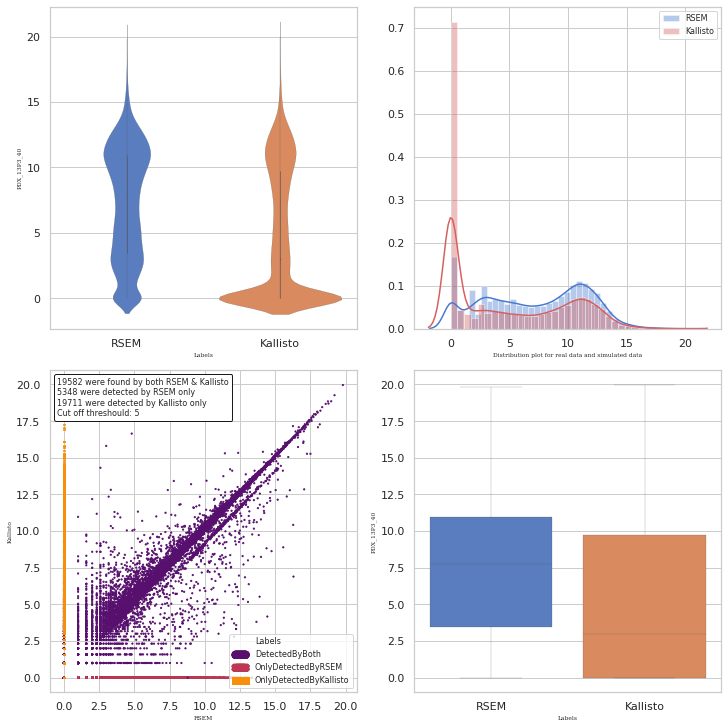

In [452]:
plotter.plotPlotBlock([test[['PDX_13P3_40']], kall[['PDX_13P3_40']]])

In [465]:
loader = DataLoader("/home/lima/Project/simulation/Comparision/high/Normalized")
test_rsem = loader.getRSEM()
test_kall = loader.getKall()

                 PDX_13P3_40  PDX_2P3_40  PDX_3P3_40  PDX_5P3_40
GeneID                                                          
ENSG00000000003    12.885911   12.869765   12.630503   13.160611
ENSG00000000005     6.978717    6.470516    6.276438    6.621493
ENSG00000000419    11.484473   11.469781   11.350171   11.563872
ENSG00000000457     8.848848    8.860944    8.604472    8.711351
ENSG00000000460     9.034429    9.228073    9.128070    9.048986
...                      ...         ...         ...         ...
ENSG00000273475     5.945941    5.945941    5.945941    5.945941
ENSG00000273479     5.945941    5.945941    5.945941    5.945941
ENSG00000273482    10.382845   10.164749   10.286109   10.372834
ENSG00000273484     5.945941    6.250008    5.945941    6.193747
ENSG00000273490     8.825894    8.173458    8.610013    8.397267

[39293 rows x 4 columns]


                 PDX_13P3_40
GeneID                      
ENSG00000000003    12.719051
ENSG00000000005     6.910806
ENSG00000000419    11.214225
ENSG00000000457     8.594492
ENSG00000000460     8.518911
...                      ...
ENSG00000273487     6.943710
ENSG00000273488     6.371859
ENSG00000273489     6.198388
ENSG00000273492     6.316029
ENSG00000273493     5.858528

[57773 rows x 1 columns]
                 PDX_13P3_40
GeneID                      
ENSG00000000003    12.885911
ENSG00000000005     6.978717
ENSG00000000419    11.484473
ENSG00000000457     8.848848
ENSG00000000460     9.034429
...                      ...
ENSG00000273475     5.945941
ENSG00000273479     5.945941
ENSG00000273482    10.382845
ENSG00000273484     5.945941
ENSG00000273490     8.825894

[39293 rows x 1 columns]
57773 genes have been detected in PDX_13P3_40 by RSEM
39293 genes have been detected in PDX_13P3_40 by kallisto
62158 genes in both dataframes
62158 labels have been attached


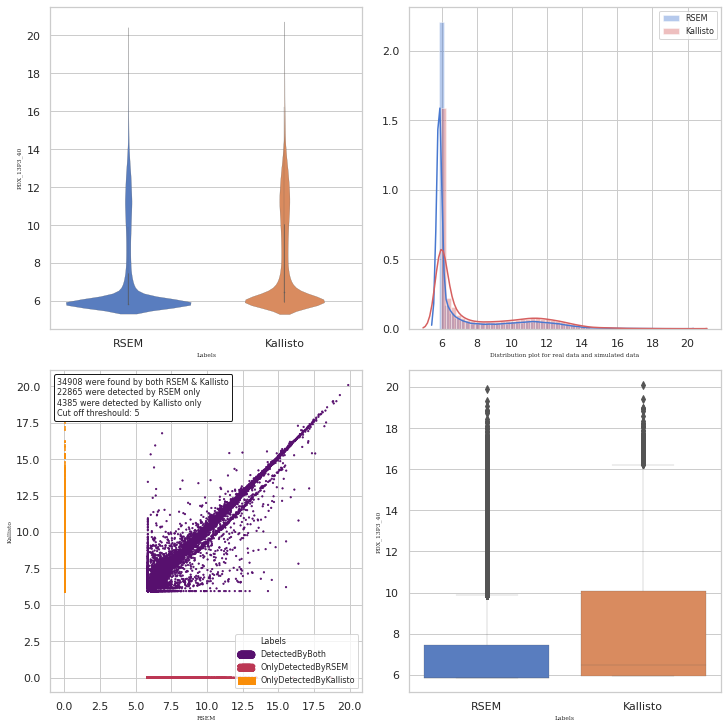

In [467]:
test_normRsem = test_rsem[5]
plotter = Plotter(5)
plotter.plotPlotBlock([test_normRsem[['PDX_13P3_40']], test_kall[['PDX_13P3_40']]])